In [1]:
import numpy as np
import pandas as pd
import scipy
from icecream import ic
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import chi2_contingency, chi2
import time

# Excercise 2

### 1. Choose a value for the probability parameter p in the geometric distribution and simulate 10,000 outcomes. You can experiment with a small, moderate and large value if you like.

In [2]:
# Number of outcomes
N = 10_000

# Probability p
p = 0.45

x = np.random.geometric(p=p, size=N)       

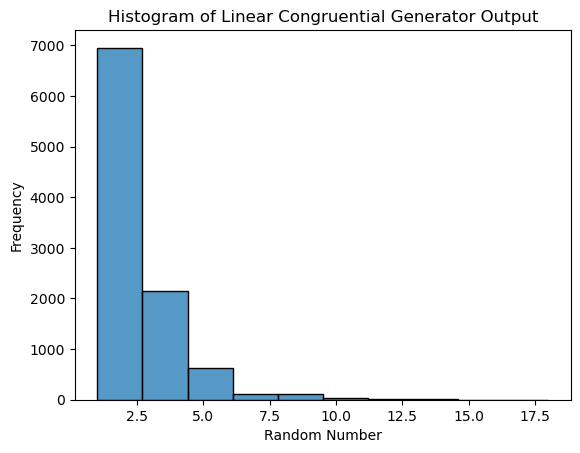

In [3]:
# Plot the histogram
sns.histplot(x, bins=10)
plt.xlabel('Random Number')
plt.ylabel('Frequency')
plt.title('Histogram of Linear Congruential Generator Output')
plt.show()

### 2. Simulate the 6 point distribution with given probabilities

First we simulate it using numpy's build in RNG as a reference

In [18]:
# Define the outcomes and their probabilities
outcomes = [1, 2, 3, 4, 5, 6]
p = [7/48, 5/48, 1/8, 1/16, 1/4, 5/16]

# Simulate 10,000 outcomes
start_time = time.time()
numpy_distribution = np.random.choice(outcomes, N, p=p)
end_time = time.time()
numpy_time = end_time - start_time


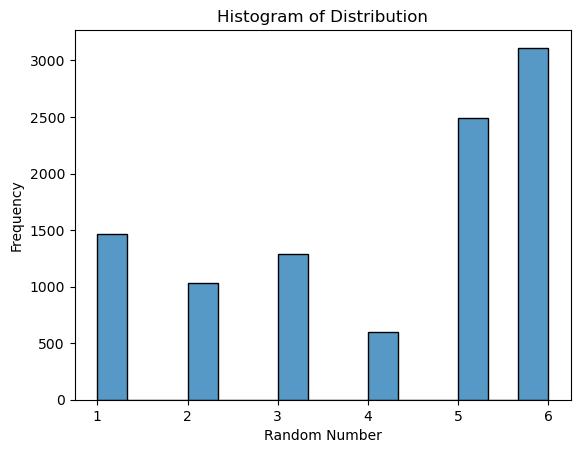

In [5]:
# Plot the histogram
sns.histplot(numpy_distribution)
plt.xlabel('Random Number')
plt.ylabel('Frequency')
plt.title('Histogram of Distribution')
plt.show()

## 2.1 Crude method

We generate the accumulated probabilities first

In [6]:
x = np.random.rand(10000)
outcomes = [1, 2, 3, 4, 5, 6]
probabilities = [7/48, 5/48, 1/8, 1/16, 1/4, 5/16]
accumulated_probabilities = [sum(probabilities[0:i+1]) for i in range(len(probabilities))]


We then loop through the probabilities for each uniformly distributed U to simulate a roll with probabilities equal to probabilities = [7/48, 5/48, 1/8, 1/16, 1/4, 5/16]

100%|██████████| 10000/10000 [00:00<00:00, 675911.95it/s]


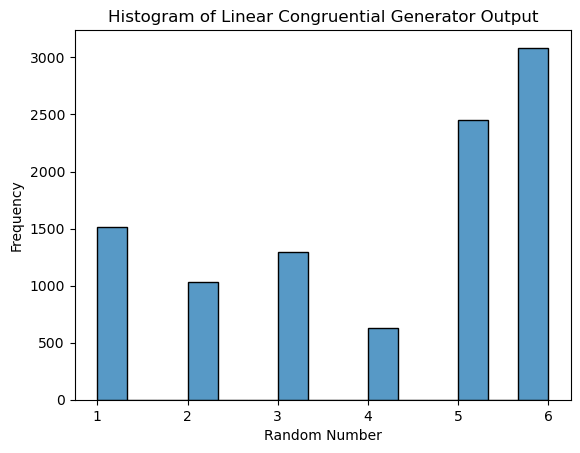

In [19]:
# We make a list of counts 
outcomes = [1, 2, 3, 4, 5, 6]
rolls = []

start_time = time.time()
for _ in tqdm(range(10000)):
    U = np.random.uniform()
    for i, prob in enumerate(accumulated_probabilities):
        if U <= prob:
            rolls.append(outcomes[i])
            break
end_time = time.time()
crude_time = end_time - start_time

crude_method = rolls

# Plot the histogram
sns.histplot(rolls)
plt.xlabel('Random Number')
plt.ylabel('Frequency')
plt.title('Histogram of Linear Congruential Generator Output')
plt.show()

## 2.2 Rejection method

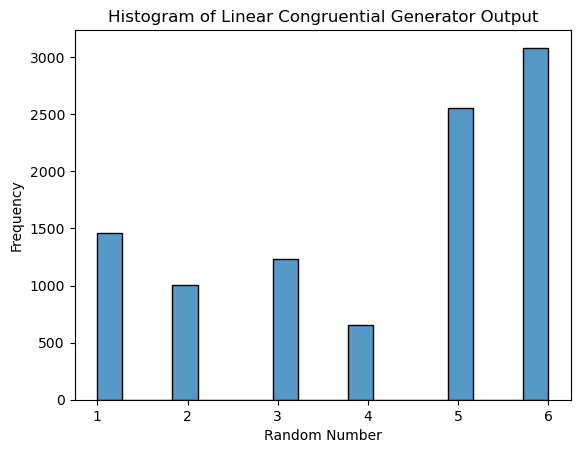

In [8]:
outcomes = [1, 2, 3, 4, 5, 6]
probabilities = [7/48, 5/48, 1/8, 1/16, 1/4, 5/16]

# We determine minimum value for C in order to accept as many rolls as possible
c = np.max(probabilities) 
rolls = []

start_time = time.time()
while len(rolls) < 10000:
    U1 = np.random.uniform()
    U2 = np.random.uniform()
    I = np.floor(6 * U1) + 1
    if U2 <= probabilities[int(I-1)] / c:
        rolls.append(int(I))
end_time = time.time()
rejection_time = end_time - start_time

rejection_method = rolls
# Plot the histogram
sns.histplot(rolls)
plt.xlabel('Random Number')
plt.ylabel('Frequency')
plt.title('Histogram of Linear Congruential Generator Output')
plt.show()

## 2.3 Alias method

In [9]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

n = 6
p = [7/48, 5/48, 1/8, 1/16, 1/4, 5/16]
L = [1, 2, 3, 4, 5, 6]
F = np.array(p) * n  # We scale the probabilities
alias = np.zeros(n, dtype=int)  # Alias
prob = np.zeros(n)


G = []  # Big
S = []  # Small

start_time = time.time()
for i, f in enumerate(F):
    if f >= 1.0:
        G.append(i)
    else:
        S.append(i)

while G and S:
    i = G.pop()  # Big index
    j = S.pop()  # Small index

    # Add indexes where scaled probabilities F is over 1 to the alias indexes 
    #at the locations where the scaled probabilities are smaller
    alias[j] = i

    # Add the scaled probability for the smaller indexes in the smaller indexes 
    prob[j] = F[j]

    F[i] = F[i] - (1 - F[j])

    if F[i] >= 1.0:
        G.append(i)
    else:
        S.append(i)

# For remaining elements in G and S
while G:
    i = G.pop()
    prob[i] = 1.0

while S:
    i = S.pop()
    prob[i] = 1.0

# List to store rolls
rolls = []

# Draw rolls using the loop structure
for _ in tqdm(range(10000)):
    a = True
    while a:
        U1 = np.random.uniform()
        I = int(np.floor(6 * U1) + 1)  # Choose a random number from the distribution
        U2 = np.random.rand()  # Generate a uniform random number
        if U2 < prob[I-1]:
            rolls.append(I)  # Append the index, +1 for 1-based indexing
        else:
            rolls.append(alias[I-1] + 1)  # Append the alias, +1 for 1-based indexing
        a = False  # Exit the while loop
end_time = time.time()

alias_time = end_time - start_time


alias_method = rolls

100%|██████████| 10000/10000 [00:00<00:00, 526896.14it/s]


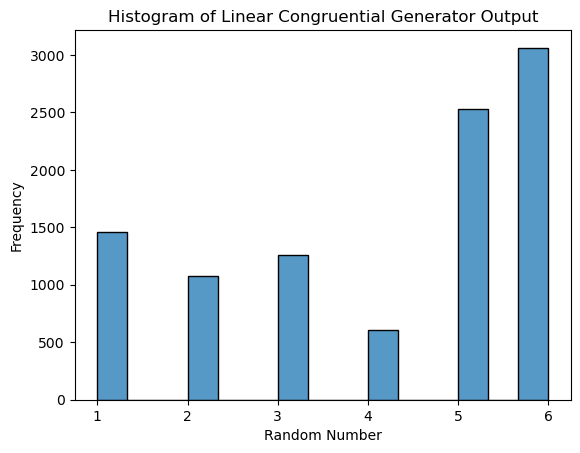

In [10]:
# Plot the results
sns.histplot(rolls)
plt.xlabel('Random Number')
plt.ylabel('Frequency')
plt.title('Histogram of Linear Congruential Generator Output')
plt.show()

In [12]:
def count_frequencies(arr):
    counts = np.bincount(arr)[1:]
    return counts

In [13]:
# Count frequencies for each method
# Create the perfect_counts array and round it
perfect_counts = np.round(np.array(p) * 10_000, 0)
perfect_counts = perfect_counts.astype(int)
numpy_counts = count_frequencies(numpy_distribution)
crude_counts = count_frequencies(crude_method)
rejection_counts = count_frequencies(rejection_method)
alias_counts = count_frequencies(alias_method)

# Create a table of frequencies
table = np.array([perfect_counts, numpy_counts, crude_counts, rejection_counts, alias_counts])
columns = ['1', '2', '3', '4', '5', '6']
methods = ['Perfect Distribution','Numpy Distribution', 'Crude Method', 'Rejection Method', 'Alias Method']

df = pd.DataFrame(table, columns=columns, index=methods)
print(df)


                         1     2     3    4     5     6
Perfect Distribution  1458  1042  1250  625  2500  3125
Numpy Distribution    1469  1033  1293  599  2493  3113
Crude Method          1436  1060  1244  609  2501  3150
Rejection Method      1460  1007  1236  657  2557  3083
Alias Method          1459  1077  1263  607  2532  3062


To compare the distributions we can perform a chi square test 

In [14]:
# Chi-Square Test
chi2_stat, p_val, dof, ex = chi2_contingency(df)

print("Chi-Square Statistic:", chi2_stat)
print("p-value:", p_val)
print("Degrees of Freedom:", dof)

Chi-Square Statistic: 10.859450719310086
p-value: 0.9497862181882478
Degrees of Freedom: 20


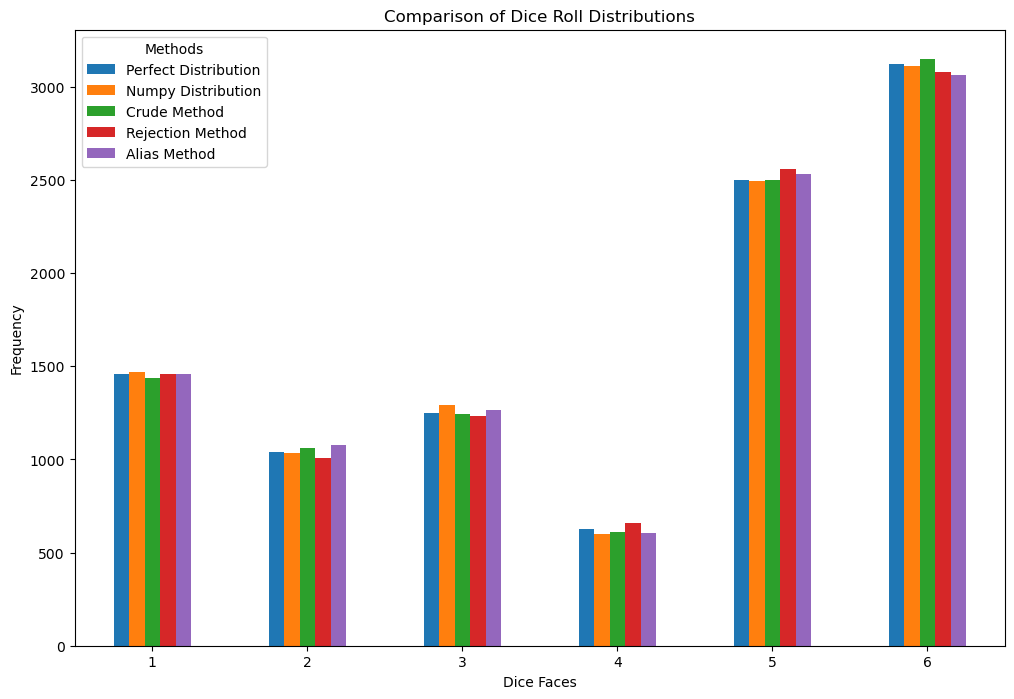

In [15]:
# Plot the distributions
df.T.plot(kind='bar', figsize=(12, 8))
plt.title('Comparison of Dice Roll Distributions')
plt.xlabel('Dice Faces')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.legend(title='Methods')
plt.show()

There is no statisticaly significant difference between the distribution methods.

We can compare the time it takes between the different methods

In [25]:
time_data = {
    'Method': ['Numpy', 'Crude', 'Rejection', 'Alias'],
    'Elapsed Time (seconds)': [numpy_time, crude_time, rejection_time, alias_time]
}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(time_data)
print(df)

      Method  Elapsed Time (seconds)
0      Numpy                0.000540
1      Crude                0.016685
2  Rejection                0.105927
3      Alias                0.020444


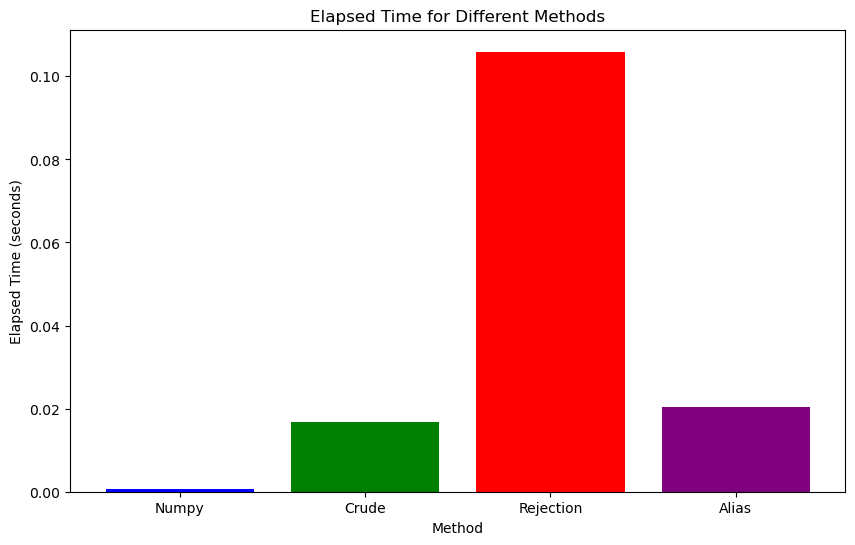

In [26]:
# Plot the times
plt.figure(figsize=(10, 6))
plt.bar(df['Method'], df['Elapsed Time (seconds)'], color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Method')
plt.ylabel('Elapsed Time (seconds)')
plt.title('Elapsed Time for Different Methods')
plt.show()

We notice that there is quite a large difference in time between the methods. Especially we see that the rejection method takes the longest time to run by far. The crude and alias methods are very similar in our examples, and the numpy method is fastest by a large factor